In [133]:
import pandas as pd
import folium as fo
import numpy as np
import datetime
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import json
pd.set_option('mode.chained_assignment', None)

# Violation frequency  
## Violation frequency by violation category  
Regrouping violations in common categories will need less plots while maintening readability and finer analysis.  
To do so, we created 5 categories (food safety, hygiene, equipment, recidivism and others).  
For the analysis, we first map violation's id to their new category and then proceed as usual.

In [161]:
import pandas as pd
import matplotlib.pyplot as plt

In [162]:
violation_category_mapping = pd.read_csv('resources/violation-id-meaning.csv').rename(columns={'Violation ID': 'id', 'Category': 'category'})
violation_category_mapping.index = violation_category_mapping.id
violation_category_mapping = violation_category_mapping.category

violation_categories = violation_category_mapping.unique()
violation_category_mapping.head()

id
1    Food safety
2    Food safety
3    Food safety
4    Food safety
5        Hygiene
Name: category, dtype: object

We also restrict the analysis to certain types of facility: ie restaurants and grocery stores.  

In [163]:
inspections = pd.read_parquet('resources/food-inspections-cleaned.parquet').rename(columns={'Inspection Date': 'date'})

In [164]:
categorized_violations = pd.read_parquet('resources/violations_oriented.parquet').rename(columns={'Violation ID': 'id', 'Inspection Date': 'date'})
categorized_violations.index = categorized_violations.date
categorized_violations['category'] = categorized_violations.id.map(lambda x: violation_category_mapping.get(x))

## Franchise oriented analysis

In [165]:
columns_rename = {'AKA Name': 'name', 'License #': 'license', 'Ward': 'ward', 'Violation IDs': 'violations', 'Inspection Date': 'date', 'Results': 'result', 'Risk': 'risk'}
columns_filter = columns_rename.values()
violations = pd.read_parquet('resources/cleaned_franchises.parquet').rename(columns=columns_rename)[columns_filter]
violations.date = violations.date.map(lambda x: x.year)
violations = violations[(violations.date > 2010) & (violations.date < 2018)]
violations.columns

Index(['name', 'license', 'ward', 'violations', 'date', 'result', 'risk'], dtype='object')

In [166]:
violation_category_mapping = pd.read_csv('resources/violation-id-meaning.csv').rename(columns={'Violation ID': 'id', 'Category': 'category'})
violation_category_mapping.index = violation_category_mapping.id
violation_category_mapping = violation_category_mapping.category

violation_categories = violation_category_mapping.unique()
'Violations categories are: ' + ' - '.join(violation_category_mapping.unique())

'Violations categories are: Food safety - Hygiene - Equipment - Recidivism - Other'

In [167]:
studied_franchises = ['SUBWAY', 'DUNKINDONUTS', 'MCDONALDS',\
                     'STARBUCKS', 'BURGERKING', 'POPEYES',\
                     'POTBELLYSANDWICH', 'CHIPOTLE', 'KFC',\
                     'HAROLDSCHICKEN', 'DOMINOS', 'WENDYS',\
                     'PIZZAHUT', 'AUBONPAIN', 'PAPAJOHNSPIZZA',\
                     'JAMBAJUICE', 'WINGSTOP', 'FRESHII',\
                     'JIMMYJOHNS', 'JJFISH',]
print('We are studying {} franchises.'.format(len(studied_franchises)))


We are studying 20 franchises.


## I] Franchises vs the rest of Chicago  
### 1] Average inspections per license 

In [168]:
licenses_per_name = violations[['name', 'license']].groupby(by='name').nunique()[['license']].rename(columns={'license': 'licenses'}).sort_values(by='licenses', ascending=False)
licenses_per_name.head()

,licenses
name,
SUBWAY,422
7ELEVEN,285
DUNKINDONUTS,271
STARBUCKS,230
MCDONALDS,173


In [169]:
inspections_per_name = violations.copy()[['name']]
inspections_per_name['inspections'] = 1
inspections_per_name = inspections_per_name.groupby(by='name').count().sort_values(by='inspections', ascending=False)
inspections_per_name.head()

,inspections
name,
SUBWAY,3149
DUNKINDONUTS,1815
MCDONALDS,1514
STARBUCKS,1100
7ELEVEN,1098


In [170]:
avg_inspections_per_license = licenses_per_name.join(inspections_per_name)
avg_inspections_per_license['inspections/license'] = avg_inspections_per_license.inspections / avg_inspections_per_license.licenses
avg_inspections_per_license = avg_inspections_per_license.drop(['inspections', 'licenses'], axis=1)
avg_inspections_per_license['is_franchise'] = avg_inspections_per_license.index.isin(studied_franchises)
avg_inspections_per_license.is_franchise = avg_inspections_per_license.is_franchise.map(lambda x: 'Franchise' if x else 'Individual')

In [171]:
avg_inspections_per_license.groupby(by='is_franchise').mean()

,inspections/license
is_franchise,
Franchise,6.351389
Individual,4.516441


Franchises are more inspected :)

### 2] Violations categories periodicity

In [172]:
exploded_violations = violations.explode('violations')
exploded_violations = exploded_violations[exploded_violations.violations != 'None']
exploded_violations.violations = exploded_violations.violations.astype('int32').map(lambda x: violation_category_mapping.get(x))
exploded_violations['is_franchise'] = exploded_violations.name.isin(studied_franchises).map(lambda x: 'Franchise' if x else 'Individual')
exploded_violations.head(5)

,name,license,ward,violations,date,result,risk,is_franchise
Inspection ID,,,,,,,,
58528,GOSU,2074097,1,Food safety,2011,Fail,High,Individual
58528,GOSU,2074097,1,Hygiene,2011,Fail,High,Individual
58528,GOSU,2074097,1,Other,2011,Fail,High,Individual
58528,GOSU,2074097,1,Hygiene,2011,Fail,High,Individual
58528,GOSU,2074097,1,Equipment,2011,Fail,High,Individual


In [173]:
violation_categories_periodicity = exploded_violations.copy()
violation_categories_periodicity = violation_categories_periodicity[['is_franchise', 'violations', 'date']]
violation_categories_periodicity['v_count'] = 1
violation_categories_periodicity = violation_categories_periodicity.groupby(by=['is_franchise', 'violations', 'date']).sum().reset_index()
violation_categories_periodicity.head()

,is_franchise,violations,date,v_count
0,Franchise,Equipment,2011,1461
1,Franchise,Equipment,2012,1341
2,Franchise,Equipment,2013,1370
3,Franchise,Equipment,2014,1565
4,Franchise,Equipment,2015,1537


We want to normalize this count by the number of inspections.

In [174]:
inspections_per_day_and_franchise = violations.copy()[['name', 'date']]
inspections_per_day_and_franchise['is_franchise'] = inspections_per_day_and_franchise.name.isin(studied_franchises).map(lambda x: 'Franchise' if x else 'Individual')
inspections_per_day_and_franchise = inspections_per_day_and_franchise.drop('name', axis=1)
inspections_per_day_and_franchise['i_count'] = 1
inspections_per_day_and_franchise = inspections_per_day_and_franchise.groupby(by=['is_franchise', 'date']).sum()
inspections_per_day_and_franchise.head()

i_count
is_franchise date         
Franchise    2011     1469
             2012     1528
             2013     1710
             2014     1910
             2015     1930

In [175]:
category_rate = inspections_per_day_and_franchise.merge(violation_categories_periodicity, left_on=['is_franchise', 'date'], right_on=['is_franchise', 'date']).rename(columns={'violations': 'category'})
category_rate['rate'] = category_rate.v_count / category_rate.i_count
category_rate = category_rate.drop(['i_count', 'v_count'], axis=1)
category_rate.head()

,is_franchise,date,category,rate
0,Franchise,2011,Equipment,0.994554
1,Franchise,2011,Food safety,0.127297
2,Franchise,2011,Hygiene,1.703880
3,Franchise,2011,Other,0.109598
4,Franchise,2011,Recidivism,0.019061


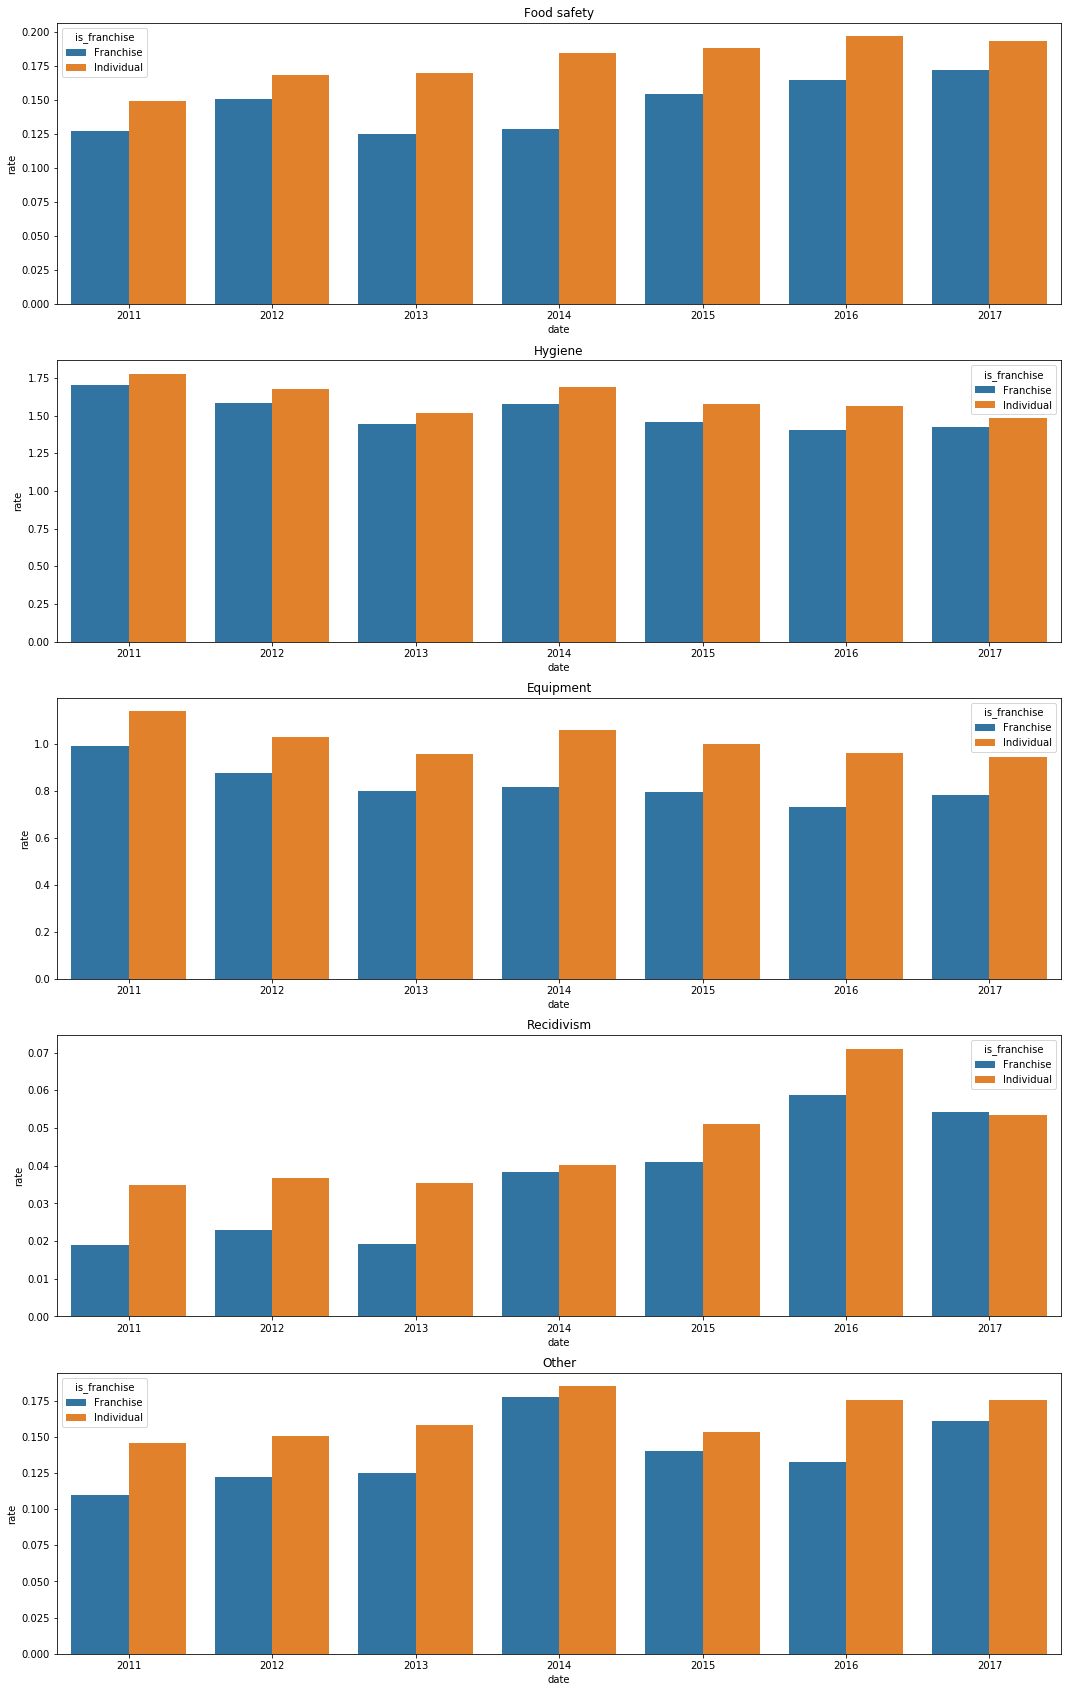

In [176]:
franchises = category_rate.is_franchise.unique()
fig, axs = plt.subplots(len(violation_categories), 1, figsize=(18,30))

for i, v_cat in enumerate(violation_categories):
    filtered = category_rate[category_rate.category == v_cat]
    sns.barplot(x='date', y='rate', hue='is_franchise', data=filtered[['date', 'is_franchise', 'rate']], ax=axs[i])
    axs[i].set_title('{}'.format(v_cat))
    #axs[i].plot(filtered.date.values, filtered.rate)

Overall, franchises have around +50% food safety violations, -25% equipment violations and more than about 2 to 5 times the amount of recidivism violations compared to non franchise stores.  

While big franchises want to maximize profit by making the most possible sales, it has a high impact on the overall sanitization of the restaurant.  
The high recidivism is surely the result of big corporation not caring enough about inspections and willing to make more profit while not caring about overall safety.

## II] Franchise groups vs each others  
This time, we will group every franchise in a group (ie: burgers, wraps, ...).  
This may reveal some interesting facts about different franchise types.

In [177]:
def franchise_map(franchise):
    if franchise in ['KFC', 'POPEYES', 'HAROLDSCHICKEN', 'WINGSTOP', 'JJFISH']: return 'Chicken/Fish'
    elif franchise in ['SUBWAY', 'POTBELLYSANDWICH', 'JIMMYJOHNS', 'AUBONPAIN']: return 'Sandwich'
    elif franchise in ['PIZZAHUT', 'DOMINOS', 'PAPAJOHNSPIZZA']: return 'Pizza'
    elif franchise in ['MCDONALDS', 'BURGERKING', 'WENDYS']: return 'Burger'
    elif franchise in ['JAMBAJUICE', 'STARBUCKS']: return 'Drink'
    return 'Other'

### 1] Average inspections per license per group

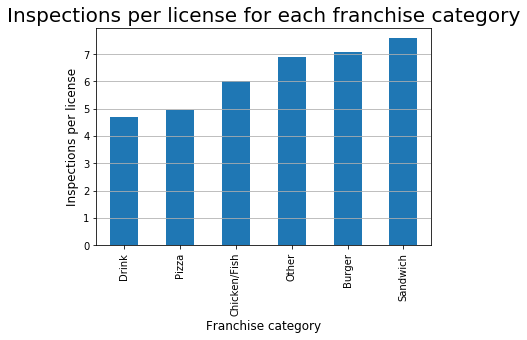

In [178]:
grouped_franchises_licenses = licenses_per_name[licenses_per_name.index.isin(studied_franchises)]
grouped_franchises_licenses.index = grouped_franchises_licenses.index.map(franchise_map)
grouped_franchises_licenses = grouped_franchises_licenses.groupby(by='name').sum()

grouped_franchises_inspections = inspections_per_name[inspections_per_name.index.isin(studied_franchises)]
grouped_franchises_inspections.index = grouped_franchises_inspections.index.map(franchise_map)
grouped_franchises_inspections = grouped_franchises_inspections.groupby(by='name').sum()

inpections_per_license_per_inspection_group = grouped_franchises_licenses.join(grouped_franchises_inspections)
inpections_per_license_per_inspection_group['rate'] = inpections_per_license_per_inspection_group.inspections / inpections_per_license_per_inspection_group.licenses

bar = inpections_per_license_per_inspection_group.rate.sort_values().plot.bar()
bar.set_title('Inspections per license for each franchise category', fontsize=20)
bar.set_xlabel('Franchise category', fontsize=12)
bar.set_ylabel('Inspections per license', fontsize=12)
bar.grid(axis='y')

Clearly, two groups are more controlled than others: burger and sandwich fast foods.  
It contrast with pizza and coffee/milkshake place that are about 30% less inspected.

### 2] Violation average per group

In [179]:
franchises_inspections = violations[violations.name.isin(studied_franchises)]

groups_inspections = franchises_inspections.copy()
groups_inspections.name = groups_inspections.name.map(franchise_map)
groups_inspections.head()

,name,license,ward,violations,date,result,risk
Inspection ID,,,,,,,
2129821,Drink,2398564,42,[37],2017,Pass,Medium
2129814,Pizza,2138095,31,[None],2017,Pass,Medium
2129808,Other,2391841,5,[21],2017,Pass w/ Conditions,Medium
2114246,Burger,2368793,28,[38],2017,Pass,Medium
2129747,Burger,2204169,3,"[35, 38]",2017,Pass,Medium


In [180]:
groups_violations = groups_inspections.explode('violations').rename(columns={'violations': 'id'})
groups_violations.head()

,name,license,ward,id,date,result,risk
Inspection ID,,,,,,,
88637,Sandwich,1357930,49,30,2011,Pass,High
88637,Sandwich,1357930,49,33,2011,Pass,High
88637,Sandwich,1357930,49,34,2011,Pass,High
88637,Sandwich,1357930,49,35,2011,Pass,High
88642,Sandwich,2013950,39,18,2011,Fail,High


In [181]:
violations_per_group = groups_violations[['name', 'id', 'date']]
violations_per_group = violations_per_group[violations_per_group.id != 'None']
violations_per_group['category'] = violations_per_group.id.astype('int32').map(violation_category_mapping.get)
violations_per_group['v_count'] = 1
violations_per_group = violations_per_group.drop('id', axis=1)

violations_per_group_overall = violations_per_group.drop('date', axis=1).groupby(by=['name','category']).sum()
violations_per_group_overall.head()

v_count
name   category            
Burger Equipment       2287
       Food safety      371
       Hygiene         4218
       Other            168
       Recidivism        85

In [182]:
avg_violations_per_group_per_inspection = violations_per_group_overall.join(grouped_franchises_inspections)
avg_violations_per_group_per_inspection['rate'] = avg_violations_per_group_per_inspection.v_count / avg_violations_per_group_per_inspection.inspections
avg_violations_per_group_per_inspection = avg_violations_per_group_per_inspection.drop(['v_count', 'inspections'], axis=1)
avg_violations_per_group_per_inspection.head()

rate
name   category             
Burger Equipment    0.948569
       Food safety  0.153878
       Hygiene      1.749482
       Other        0.069681
       Recidivism   0.035255

In [183]:
avg_violations_per_group_per_inspection.reset_index().pivot(index='name', columns='category', values='rate')

category,Equipment,Food safety,Hygiene,Other,Recidivism
name,,,,,
Burger,0.948569,0.153878,1.749482,0.069681,0.035255
Chicken/Fish,0.928652,0.114383,1.868063,0.164779,0.048698
Drink,0.593178,0.085691,1.256240,0.079867,0.019967
Other,0.894671,0.179186,1.464121,0.193454,0.041544
Pizza,0.742215,0.081315,1.391003,0.238754,0.044983
Sandwich,0.736560,0.164923,1.317928,0.142788,0.036244


### 3] Violation periodicity per group

In [184]:
inspections_per_group_per_day = groups_inspections[['name', 'date']]
inspections_per_group_per_day['i_count'] = 1
inspections_per_group_per_day = inspections_per_group_per_day.groupby(by=['name', 'date']).sum()
inspections_per_group_per_day.head()

i_count
name   date         
Burger 2011      340
       2012      324
       2013      347
       2014      350
       2015      414

In [185]:
violations_per_group_per_day = violations_per_group.copy()
violations_per_group_per_day = violations_per_group_per_day.groupby(by=['name', 'category', 'date']).sum().reset_index('category')
violations_per_group_per_day.head()

category  v_count
name   date                    
Burger 2011  Equipment      430
       2012  Equipment      340
       2013  Equipment      323
       2014  Equipment      333
       2015  Equipment      346

In [186]:
category_rate_per_group = inspections_per_group_per_day.join(violations_per_group_per_day)
category_rate_per_group['rate'] = category_rate_per_group.v_count / category_rate_per_group.i_count
category_rate_per_group = category_rate_per_group.drop(['i_count', 'v_count'], axis=1).reset_index()
category_rate_per_group.head()

,name,date,category,rate
0,Burger,2011,Equipment,1.264706
1,Burger,2011,Food safety,0.158824
2,Burger,2011,Hygiene,2.014706
3,Burger,2011,Other,0.044118
4,Burger,2011,Recidivism,0.017647


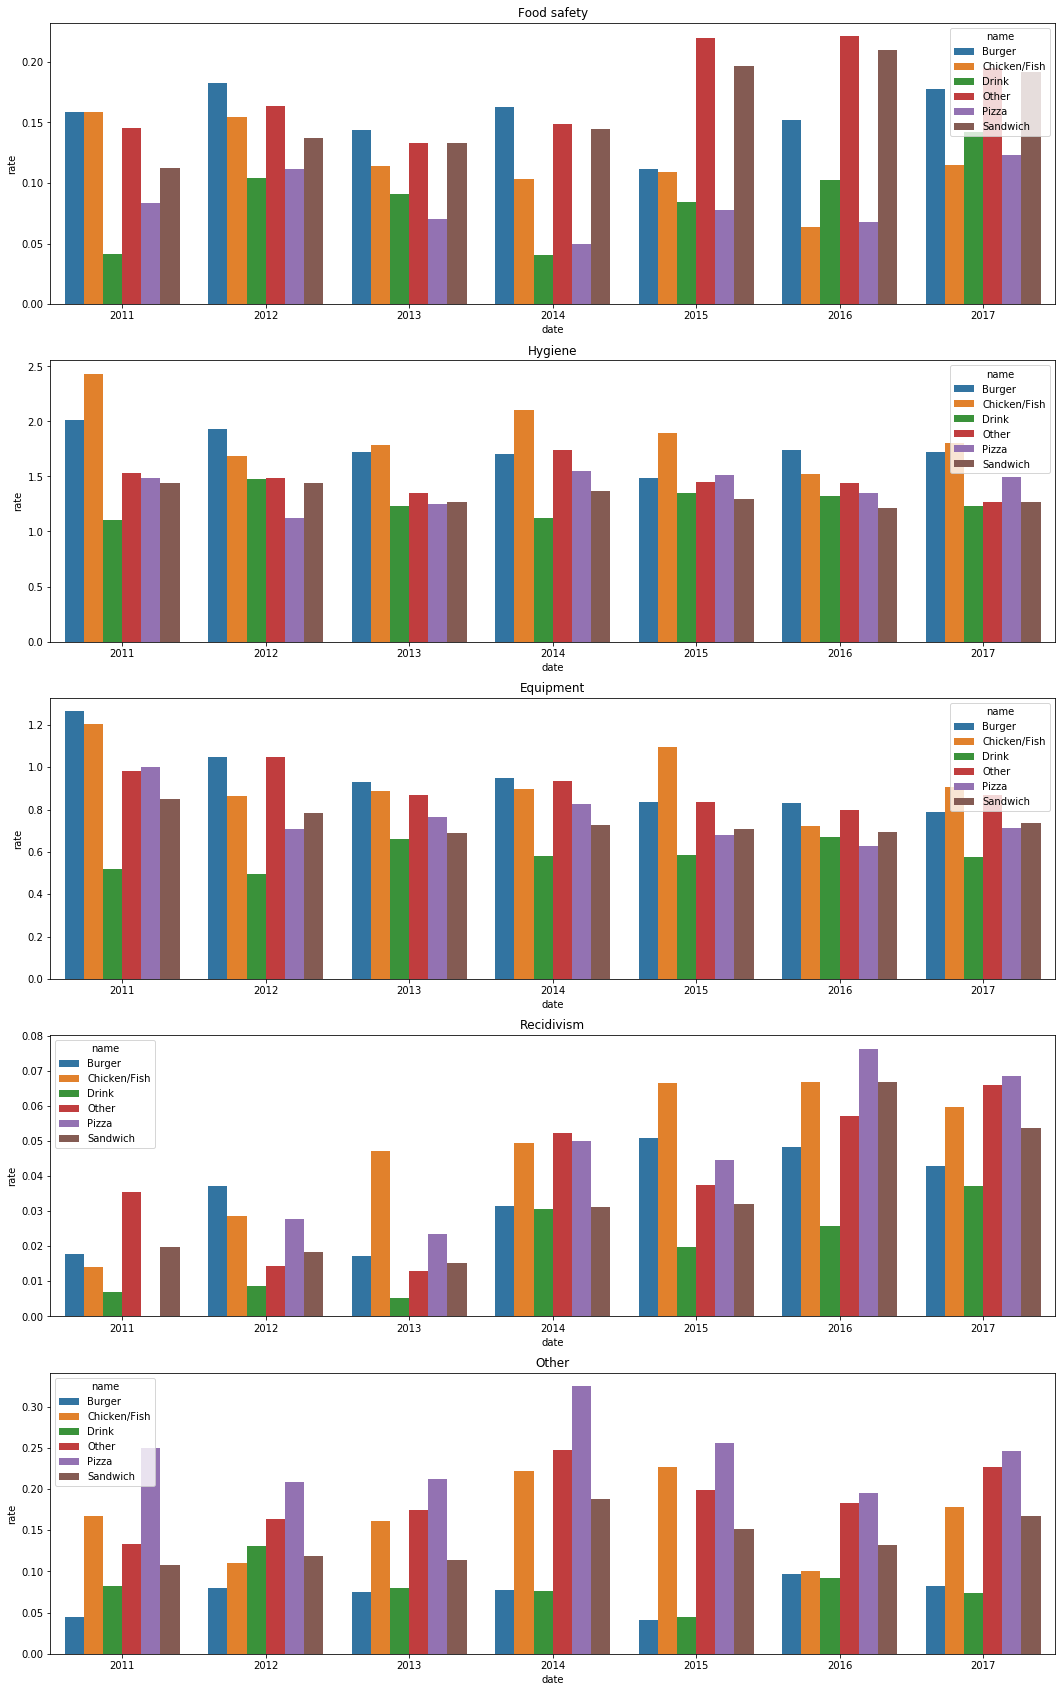

In [191]:
groups = category_rate_per_group.name.unique()
franchises = category_rate.is_franchise.unique()
fig, axs = plt.subplots(len(violation_categories), 1, figsize=(18,30))

for i, v_cat in enumerate(violation_categories):
    filtered = category_rate_per_group[category_rate_per_group.category == v_cat]
    sns.barplot(x='date', y='rate', hue='name', data=filtered[['date', 'name', 'rate']], ax=axs[i])
    axs[i].set_title('{}'.format(v_cat))
    #axs[i].plot(filtered.date.values, filtered.rate)


## II] Franchise group members vs each others (per month)

In [192]:
franchises_inspections = violations[violations.name.isin(studied_franchises)]
franchises_inspections['group'] = franchises_inspections.name.map(franchise_map)

inspections_per_franchises = franchises_inspections[['name', 'group', 'date']]
inspections_per_franchises['i_count'] = 1
inspections_per_franchises = inspections_per_franchises.groupby(by=['name', 'group', 'date']).sum()
inspections_per_franchises.head()

i_count
name      group    date         
AUBONPAIN Sandwich 2011       27
                   2012       23
                   2013       29
                   2014       30
                   2015       28

In [193]:
violations_per_franchise = franchises_inspections.explode('violations')
violations_per_franchise = violations_per_franchise[violations_per_franchise.violations != 'None']
violations_per_franchise['category'] = violations_per_franchise.violations.astype('int32').map(violation_category_mapping.get)
violations_per_franchise = violations_per_franchise[['name', 'group', 'category', 'date']]
violations_per_franchise['v_count'] = 1
violations_per_franchise = violations_per_franchise.groupby(by=['name', 'group', 'category', 'date']).sum().reset_index('category')
violations_per_franchise.head()

category  v_count
name      group    date                    
AUBONPAIN Sandwich 2011  Equipment       18
                   2012  Equipment       20
                   2013  Equipment       25
                   2014  Equipment       15
                   2015  Equipment       14

In [199]:
merged = inspections_per_franchises.join(violations_per_franchise)
merged['rate'] = merged.v_count / merged.i_count
merged = merged.drop(['v_count', 'i_count'], axis = 1).reset_index()
merged.head(10)

,name,group,date,category,rate
0,AUBONPAIN,Sandwich,2011,Equipment,0.666667
1,AUBONPAIN,Sandwich,2011,Food safety,0.074074
2,AUBONPAIN,Sandwich,2011,Hygiene,1.296296
3,AUBONPAIN,Sandwich,2012,Equipment,0.869565
4,AUBONPAIN,Sandwich,2012,Food safety,0.260870
5,AUBONPAIN,Sandwich,2012,Hygiene,1.695652
6,AUBONPAIN,Sandwich,2012,Other,0.086957
7,AUBONPAIN,Sandwich,2013,Equipment,0.862069
8,AUBONPAIN,Sandwich,2013,Food safety,0.103448
9,AUBONPAIN,Sandwich,2013,Hygiene,1.344828


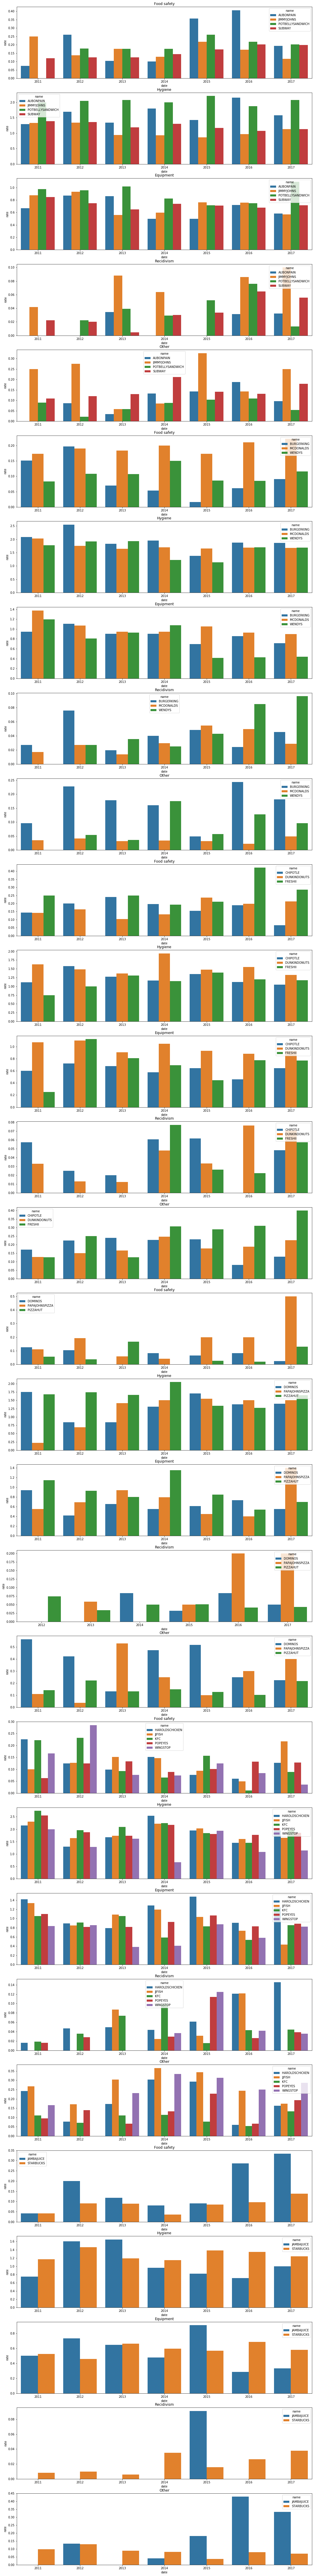

In [201]:
groups = merged.group.unique()
names = []
for group in groups:
    names.append(merged[merged.group == group].name.unique())
    
fig, axs = plt.subplots(len(violation_categories) * len(groups), 1, figsize=(18,160))

for i, group in enumerate(groups):
    group_rate = merged[merged.group == group]
    
    for k, v_cat in enumerate(violation_categories):
        filtered = group_rate[group_rate.category == v_cat]
        sns.barplot(x='date', y='rate', hue='name', data=filtered[['date', 'name', 'rate']], ax=axs[k + i * len(violation_categories)])
        axs[k + i * len(violation_categories)].set_title('{}'.format(v_cat))
        #axs[i].plot(filtered.date.values, filtered.rate)